#### 必要なライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import japanize_matplotlib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm


#### 共通関数のインポート
著者が学習用、予測用、学習用ログ解析用、図示用の関数を用意してくださっているのでそちらを利用する

In [2]:
!git clone https://github.com/makaishi2/pythonlibs.git

from pythonlibs.torch_lib1 import *

fatal: destination path 'pythonlibs' already exists and is not an empty directory.


#### GPUの確認

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データの準備

In [4]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from io import BytesIO

# Define a custom transform to upscale images
class UpscaleTransform:
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            # If img is a tensor, convert it to PIL image
            img = transforms.ToPILImage()(img)

        # Convert PIL image to tensor
        img_tensor = transforms.ToTensor()(img).unsqueeze(0)
        
        # Calculate the new size
        new_size = [int(d * self.scale_factor) for d in img_tensor.shape[2:]]
        
        # Upsample the image
        img_tensor = F.interpolate(img_tensor, size=new_size, mode='bilinear', align_corners=False)
        
        # Convert tensor back to PIL image
        img = transforms.ToPILImage()(img_tensor.squeeze(0))
        return img


# Define transformations including upscaling

scale_factor=1

transform_train = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image
    #transforms.Lambda(lambda x: UpscaleTransform(scale_factor)(x)),  # Upscale the image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
])
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Randomly erase part of the image

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
])

# Define datasets
train_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/test', transform=transform)
val_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/val_reorganized', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

print(f"Train loader has {len(train_loader.dataset)} images.")
print(f"Test loader has {len(test_loader.dataset)} images.")
print(f"Validation loader has {len(val_loader.dataset)} images.")


Train loader has 100000 images.
Test loader has 10000 images.
Validation loader has 10000 images.


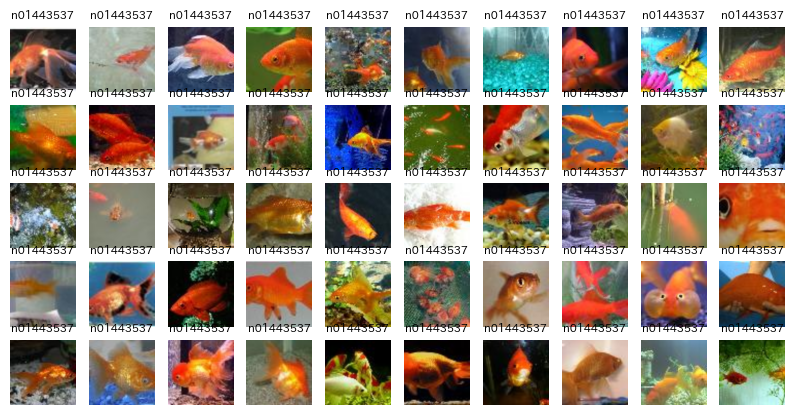

In [7]:
# Get class names (folder names) from the val_dataset
class_names = val_dataset.classes

# Get a batch of data from the val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Function to convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Function to show 50 images with their corresponding folder names
def show_images(images, labels, class_names, num_images=50):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)  # Arrange images in a 10x10 grid
        imshow(images[i])
        folder_label = class_names[labels[i].item()]  # Get folder name using label
        plt.title(folder_label, fontsize=8)  # Display folder name
        plt.axis('off')
    plt.show()

# Show 50 images and their folder names
show_images(images[:50], labels[:50], class_names)

#### Data Augmentation

#### CNNドロップアウト

In [12]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))  # 64x64x3 → 64x64x32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))  # 64x64x32 → 64x64x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))  # 32x32x32 → 32x32x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))  # 32x32x64 → 32x32x64
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1)) # 16x16x64 → 16x16x128
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1)) # 16x16x128 → 16x16x128
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(524288, 128)  # 8x8x128 → 8192
        self.l2 = nn.Linear(128, 200)  # 128 → 200
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

In [13]:
import numpy as np
import torch
import random

# 乱数の固定化
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# モデルインスタンス生成
net = CNN_v3(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# 訓練と検証
num_epochs = 25
history15 = np.zeros((0, 5))
history15 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history15)

# 評価履歴の表示
evaluate_history(history15)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history15)

  0%|          | 0/2000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.56 GiB. GPU 0 has a total capacity of 11.76 GiB of which 961.12 MiB is free. Process 227790 has 102.00 MiB memory in use. Process 906679 has 10.71 GiB memory in use. Of the allocated memory 10.19 GiB is allocated by PyTorch, and 386.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Resnet構造

In [8]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [1/25], loss: 4.64560 acc: 0.06059 val_loss: 4.16235, val_acc: 0.10930


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [2/25], loss: 3.79264 acc: 0.16814 val_loss: 3.45836, val_acc: 0.21490


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [3/25], loss: 3.23737 acc: 0.25986 val_loss: 2.99971, val_acc: 0.30400


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [4/25], loss: 2.83906 acc: 0.33285 val_loss: 2.69941, val_acc: 0.36250


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [5/25], loss: 2.53540 acc: 0.39308 val_loss: 2.45798, val_acc: 0.41330


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [6/25], loss: 2.29774 acc: 0.44222 val_loss: 2.32081, val_acc: 0.43780


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [7/25], loss: 2.10098 acc: 0.48334 val_loss: 2.23667, val_acc: 0.45970


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [8/25], loss: 1.93332 acc: 0.51933 val_loss: 2.13685, val_acc: 0.48400


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [9/25], loss: 1.77902 acc: 0.55244 val_loss: 2.03092, val_acc: 0.50210


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [10/25], loss: 1.63917 acc: 0.58262 val_loss: 2.01903, val_acc: 0.51540


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [11/25], loss: 1.51255 acc: 0.61095 val_loss: 1.96959, val_acc: 0.52780


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [12/25], loss: 1.39425 acc: 0.63688 val_loss: 1.97107, val_acc: 0.53100


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [13/25], loss: 1.27475 acc: 0.66402 val_loss: 1.97693, val_acc: 0.53660


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [14/25], loss: 1.17038 acc: 0.68775 val_loss: 2.00995, val_acc: 0.53490


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [15/25], loss: 1.06476 acc: 0.71326 val_loss: 2.02611, val_acc: 0.54110


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [16/25], loss: 0.96842 acc: 0.73414 val_loss: 2.05235, val_acc: 0.54450


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [17/25], loss: 0.87372 acc: 0.75654 val_loss: 2.13444, val_acc: 0.53670


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [18/25], loss: 0.78579 acc: 0.78016 val_loss: 2.16025, val_acc: 0.54200


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [19/25], loss: 0.71359 acc: 0.79690 val_loss: 2.20685, val_acc: 0.54160


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [20/25], loss: 0.63907 acc: 0.81609 val_loss: 2.24033, val_acc: 0.54000


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [21/25], loss: 0.58091 acc: 0.83104 val_loss: 2.36330, val_acc: 0.53370


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [22/25], loss: 0.52184 acc: 0.84717 val_loss: 2.41162, val_acc: 0.53880


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [23/25], loss: 0.47792 acc: 0.85862 val_loss: 2.48455, val_acc: 0.53000


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [24/25], loss: 0.43050 acc: 0.87055 val_loss: 2.51682, val_acc: 0.54010


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [25/25], loss: 0.40017 acc: 0.87908 val_loss: 2.62456, val_acc: 0.53040
初期状態: 損失: 4.16235 精度: 0.10930
最終状態: 損失: 2.62456 精度: 0.53040


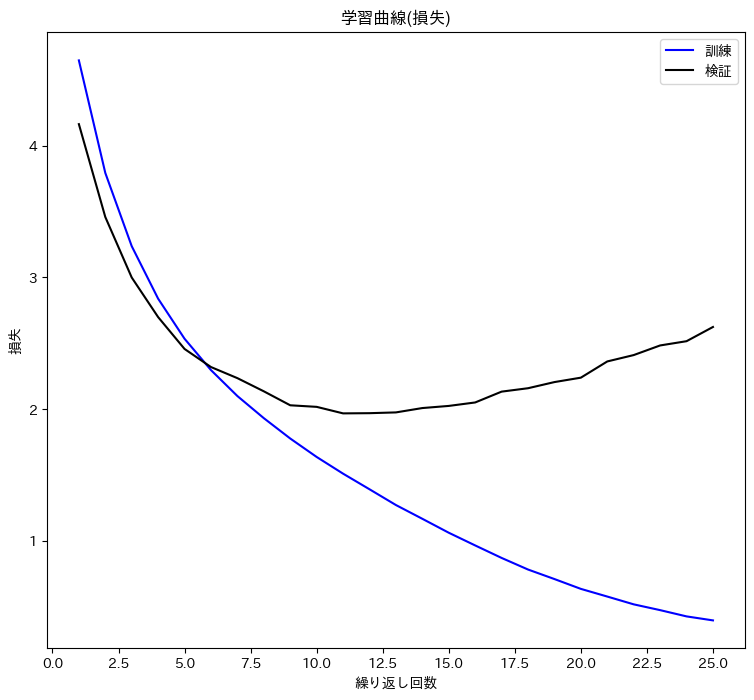

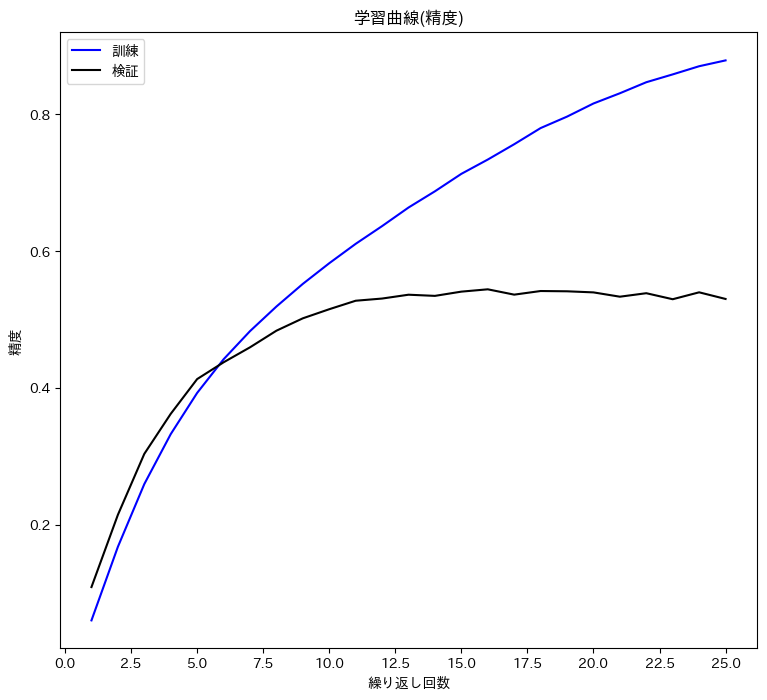

In [13]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 25
history18 = np.zeros((0, 5))
history18 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history18)

# 評価履歴の表示
evaluate_history(history18)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history18)


過学習を防ぐため、dropoutを増加する

In [5]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Apply dropout
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(dropout_rate) 
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_rate=0.5):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

   
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [1/20], loss: 4.67853 acc: 0.05419 val_loss: 4.25134, val_acc: 0.09960


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [2/20], loss: 3.86405 acc: 0.15329 val_loss: 3.76607, val_acc: 0.16840


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [3/20], loss: 3.32721 acc: 0.24178 val_loss: 3.19373, val_acc: 0.27350


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [4/20], loss: 2.96830 acc: 0.30833 val_loss: 2.93631, val_acc: 0.31580


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [5/20], loss: 2.71302 acc: 0.35706 val_loss: 2.80248, val_acc: 0.35300


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [6/20], loss: 2.50663 acc: 0.39942 val_loss: 2.64665, val_acc: 0.37890


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [7/20], loss: 2.33774 acc: 0.43322 val_loss: 2.57502, val_acc: 0.39690


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [8/20], loss: 2.19513 acc: 0.46371 val_loss: 2.43206, val_acc: 0.42670


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [9/20], loss: 2.06288 acc: 0.48915 val_loss: 2.34824, val_acc: 0.45010


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [10/20], loss: 1.94512 acc: 0.51656 val_loss: 2.26258, val_acc: 0.46410


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [11/20], loss: 1.84069 acc: 0.53877 val_loss: 2.26215, val_acc: 0.47350


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [12/20], loss: 1.74090 acc: 0.55763 val_loss: 2.24472, val_acc: 0.47730


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [13/20], loss: 1.65186 acc: 0.57701 val_loss: 2.20877, val_acc: 0.48950


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [14/20], loss: 1.56792 acc: 0.59459 val_loss: 2.21927, val_acc: 0.49170


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [15/20], loss: 1.48512 acc: 0.61420 val_loss: 2.15897, val_acc: 0.50040


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [16/20], loss: 1.41204 acc: 0.62955 val_loss: 2.21086, val_acc: 0.50100


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [17/20], loss: 1.33991 acc: 0.64767 val_loss: 2.29471, val_acc: 0.49650


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [18/20], loss: 1.27085 acc: 0.66195 val_loss: 2.24877, val_acc: 0.50600


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [19/20], loss: 1.20801 acc: 0.67720 val_loss: 2.33091, val_acc: 0.49790


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [20/20], loss: 1.14291 acc: 0.69119 val_loss: 2.23855, val_acc: 0.51640
初期状態: 損失: 4.25134 精度: 0.09960
最終状態: 損失: 2.23855 精度: 0.51640


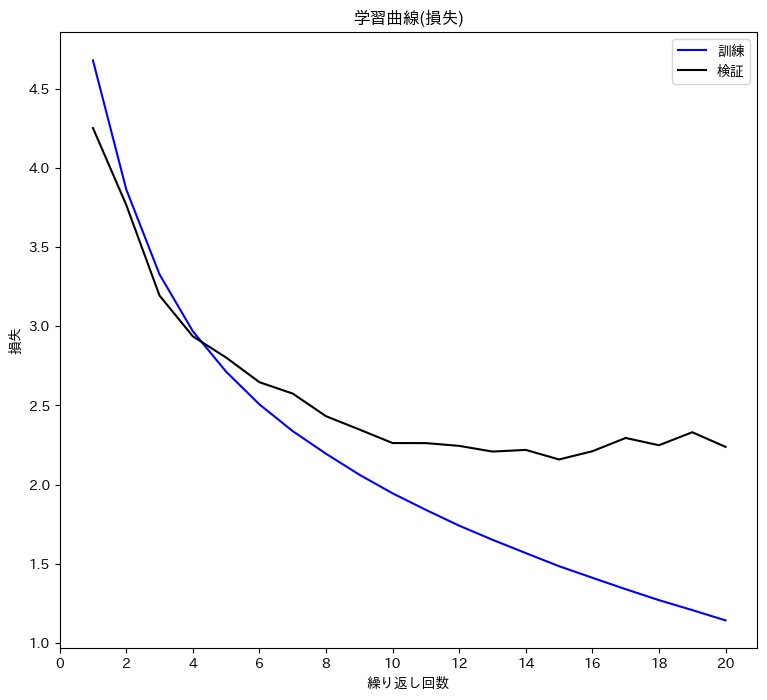

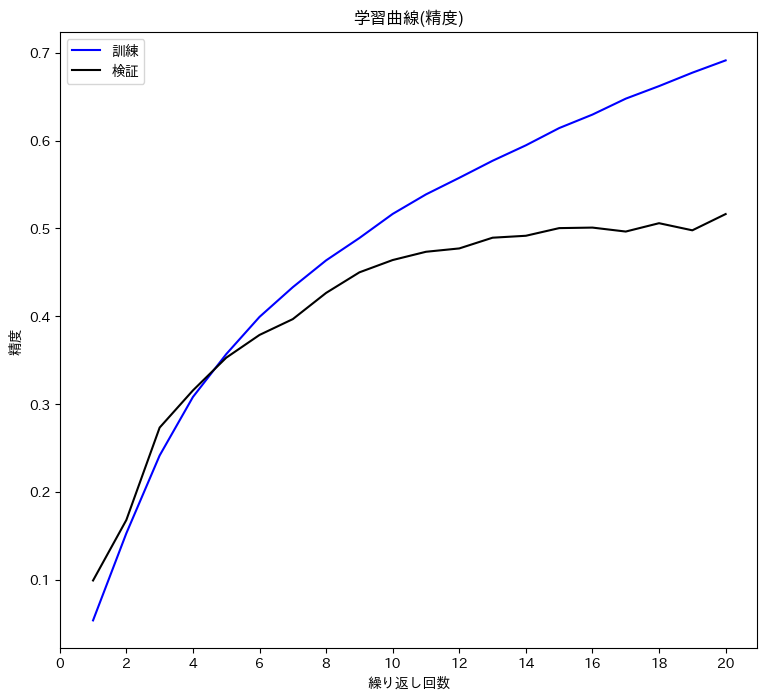

In [6]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 20
history19 = np.zeros((0, 5))
history19 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history19)

# 評価履歴の表示
evaluate_history(history19)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history19)
